In [1]:

from esmvalcore.config import CFG
from esmvalcore.dataset import Dataset

CFG.load_from_file('/home/189/fc6164/esmValTool/config-fc-copy.yml')

### Datasets

In [2]:

obs = Dataset(
    short_name='tos',
    dataset='NOAA-ERSSTv5',
    mip="Omon",
    project='OBS6',
    type='reanaly',
    timerange="1900/2019",
    tier=2)
# list(obs.from_files())
len(obs.files)

2

In [3]:

## model
var = Dataset(
    short_name='tos',
    mip='Omon',
    project='CMIP6',
    activity='CMIP',
    dataset='ACCESS-CM2',
    ensemble='r1i1p1f1',
    institute='*',
    grid='*',
    exp='historical',
    # timerange='1979/2019',
    # derive='true'
)

var_noarea = var.copy()

var.add_supplementary(short_name='areacello', mip='Ofx')
var.find_files()
# list(var.from_files())[0].files
var.files,var.supplementaries[0].files


([LocalFile('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Omon/tos/gn/v20191108/tos_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc')],
 [LocalFile('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Ofx/areacello/gn/v20191108/areacello_Ofx_ACCESS-CM2_historical_r1i1p1f1_gn.nc')])

In [4]:
import iris
from esmvalcore.preprocessor import (
                detrend, # dimension, method, 
                meridional_statistics, # 
                zonal_statistics,
                area_statistics,
                regrid, #esmf bilinear
                mask_landsea,
                anomalies,
                extract_month, 
                mask_inside_range, mask_above_threshold, mask_below_threshold,
                extract_region, # equatorial pacific #1 - 150°E-90°W, zonal 5°S-5°N average
                climate_statistics,# month mean, standard deviation
                rolling_window_statistics) 

import numpy as np
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs


In [5]:
## 
def nino3_4ssta(cube):
    cube = extract_region(cube, 190, 240, -5, 5) #
    # cube = regrid(cube, target_grid="1x1", scheme="linear")   
    
    # triangle weighted- double smoothed
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    
    cube = area_statistics(cube, 'mean')
    cube = extract_month(cube, 12)
    cube = anomalies(cube, period='monthly', standardize=True)  #normalise
  
    return cube

def eq_ssta(cube):
    cube = extract_region(cube, 150, 270, -5, 5)
    # season cycle? detrend? #convert units
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = extract_month(cube, 12)
    cube = anomalies(cube,period='monthly')
    cube = regrid(cube, target_grid="1x1", scheme="linear") 
    
    cube = meridional_statistics(cube, 'mean') #
     # weighted running average 5-degree
    cube = rolling_window_statistics(cube, coordinate='longitude', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='longitude', operator='mean', window_length=5)
    return cube


def enso_events(cube):
    # mean, std = cube.data.mean(), cube.data.std() #normalised, use 0.75
    # range1, range2 = mean-0.75*std, mean + 0.75*std 
    
    a_events = mask_to_years(mask_above_threshold(cube.copy(), -0.75))
    o_events = mask_to_years(mask_below_threshold(cube.copy(), 0.75))
    return {'nina':a_events, 'nino':o_events}

def mask_to_years(events):
    # build time with mask
    maskedTime = np.ma.masked_array(events.coord('time').points, mask=events.data.mask)
    # print(f'events cube shape: {events.shape}')
    # return years
    return [events.coord('time').units.num2date(time).year for time in maskedTime.compressed()]

# Diversity - get zonal location of max and min
def diversity(ssta_cube, events_dict): #2 masks/events list
    # each enso year, max/min SSTA, get longitude
    res_lon = {}
    for enso, events in events_dict.items():
        year_enso = iris.Constraint(time=lambda cell: cell.point.year in events)
        cube = ssta_cube.extract(year_enso)
        if enso == 'nina':
            cube = cube * -1
        #iterate through cube, each time get max/min value and return lon
        loc_ls = []
        for yr_slice in cube.slices(['longitude']):

            indx = np.argmax(yr_slice.data) # if nina multiply by -1 or min
            loc_ls.append(cube.coord('longitude').points[indx])

        res_lon[enso] = loc_ls

    return res_lon # return data to plot 

# IQR and abs((model-ref)/ref)*100
def iqr(data):
    #calculate interquartile range 
    q3, q1 = np.percentile(data, [75 ,25])
    print(q3, q1)
    iqr = q3 - q1
    return iqr
    
def compute(obs_iqr, mod_iqr):
    return abs((mod_iqr-obs_iqr)/obs_iqr)*100

In [7]:
datasets = [var, obs]

#plot 1
process = {}
metric = []
for ds in datasets:
    nino_res = nino3_4ssta(ds.load())
    events = enso_events(nino_res)

    eq_res = eq_ssta(ds.load())
    results_lon = diversity(eq_res, events)
    results_lon['enso'] = results_lon['nino'] + results_lon['nina']
    print(ds['dataset'], 'enso IQR:', iqr(results_lon['enso'])) 
    process[ds['dataset']] = results_lon
    metric.append(iqr(results_lon['enso']))#plot with label

print('metric: ', compute(metric[1],metric[0]))


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along second dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'cell index along second dimension'. Ignoring bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/coords.py:2153: IrisVagueMetadataWarning: Cannot check if coordinate is contiguous: Invalid operation for 'cell index along first dimension', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully d

events cube shape: (164,)
events cube shape: (164,)


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'longitude' were ignored in the rolling window operation.
  warnings.warn(


245.5 219.0
ACCESS-CM2 enso IQR: 26.5
245.5 219.0


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


events cube shape: (119,)
events cube shape: (119,)


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(


235.5 194.5
NOAA-ERSSTv5 enso IQR: 41.0
235.5 194.5
metric:  35.36585365853659


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'longitude' were ignored in the rolling window operation.
  warnings.warn(


Text(0.75, 0.8, '* observation')

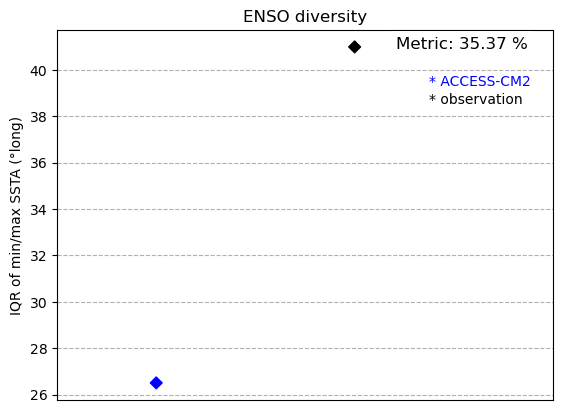

In [16]:


plt.scatter(range(len(metric)), metric, c=['blue','black'], marker='D')

plt.xlim(-0.5,2)#range(-1,3,1)) #['model','obs']
plt.xticks([])

plt.ylabel('IQR of min/max SSTA (°long)')
plt.grid(linestyle='--', axis='y')
plt.title('ENSO diversity')

metricval = compute(metric[1],metric[0])
plt.text(0.95, 0.95, f'Metric: {metricval:.2f} %', fontsize=12, ha='right', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(0.75,0.85, '* ACCESS-CM2', color='blue',transform=plt.gca().transAxes)
plt.text(0.75,0.8, '* observation', color='black',transform=plt.gca().transAxes)
# plt.legend(loc='lower right')


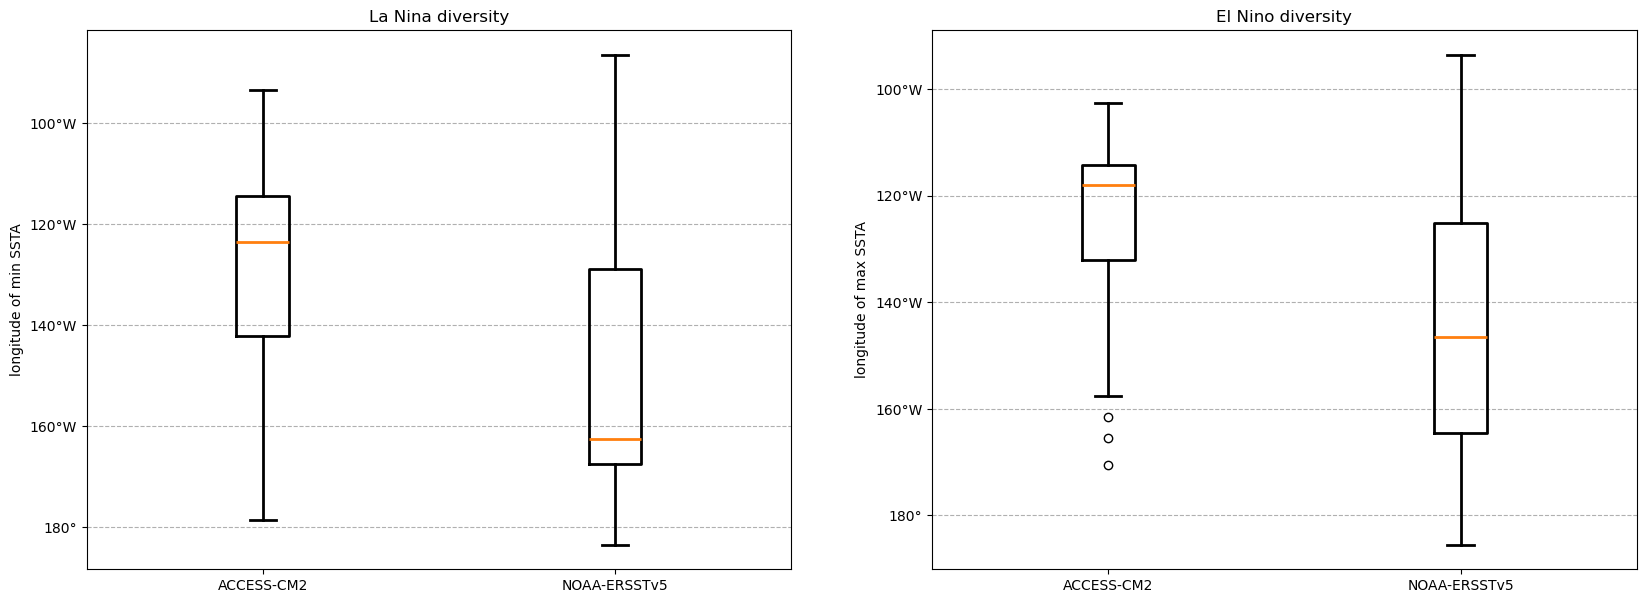

In [39]:

def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'


fig = plt.figure(figsize=(20, 7))
nina = [process[ds]['nina'] for ds in process.keys()] # subplots for nina and nino
nino = [process[ds]['nino'] for ds in process.keys()]

ax1 = plt.subplot(121)
bplt = ax1.boxplot(nina, labels=process.keys())
for k in bplt.keys():
    plt.setp(bplt[k], linewidth=2)
# colours = ['blue','black']
# for k in ['boxes','whiskers','caps']:
#     for patch, colour in zip(bplt[k], ):
#         # patch.set_color(colour)
#         patch.set_linewidth(2)
#         if k == 'boxes':
#             patch.set_fill(False)
ax1.set_title('La Nina diversity')
plt.ylabel('longitude of min SSTA')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_longitude))
plt.grid(linestyle='--', axis='y')

ax1 = plt.subplot(122)
bplt = ax1.boxplot(nino, labels=process.keys())
for k in bplt.keys():
    plt.setp(bplt[k], linewidth=2)
plt.title('El Nino diversity')
plt.ylabel('longitude of max SSTA')
plt.grid(linestyle='--', axis='y')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

In [ ]:
qplt.plot(nino3_4ssta(var.load()))